# Neutrino interaction time reconstruction (nuvT reco)

## Goal:

The goal of this project is to develop a neural network that uses the scintillation light produced in SBND, a liquid argon TPC exposed to a neutrino beam at Fermilab. The neural network uses the number of photoelectrons observed in each of the channels in an event as input. The output estimate is the temporal coordinate of the neutrino interaction.

## Objectives: 


1- Suppress cosmics. Neutrinos should come in packets (the proton beam from which they are created sends packets of protons) while cosmics (mainly muons) have a random distribution. So if you know how to match the detector light with the trace and the interaction time you can differentiate neutrino events from noise.   
2- Search for BSM phenomena. Search between neutrino packets for packet tails that should not appear. Search if they agree with m-LLP (massive long live particles) or HNLs modeling.

## Implementation:

This program implements a CNN composed of convolutional layers (along with MaxPooling) followed by a fully connected network. The input consists of "images" with the spatial correlation of the detector map, forming four layers (separating visible and ultraviolet detectors; and both volumes).

## Import libraries:

In [27]:
from imports import *

## Root file analysis

The data corresponds to the Monte Carlo simulation of the SBND experiment. It was obtained by simulating the creation of neutrinos in the beam and their subsequent interaction in SBND, as well as the simulation of the detector's response to the particles resulting from the interaction of the neutrinos.

In [22]:
file_path = '/data/vidales/opana_tree_combined_v2609.root'
file = uproot.open(file_path)
optree = file['opanatree']['OpAnaTree'] # Tree con número de fotoelectrones
print("Keys in optree:", optree.keys())

Keys in optree: ['eventID', 'runID', 'subrunID', 'nuvX', 'nuvY', 'nuvZ', 'nuvT', 'nuvE', 'stepX', 'stepY', 'stepZ', 'stepT', 'dE', 'energydep', 'energydepX', 'energydepY', 'energydepZ', 'E', 'StartPx', 'StartPy', 'StartPz', 'EndPx', 'EndPy', 'EndPz', 'process', 'trackID', 'motherID', 'PDGcode', 'InTimeCosmics', 'InTimeCosmicsTime', 'dEtpc', 'dEpromx', 'dEpromy', 'dEpromz', 'dEspreadx', 'dEspready', 'dEspreadz', 'dElowedges', 'dEmaxedges', 'nopflash', 'flash_id', 'flash_time', 'flash_total_pe', 'flash_pe_v', 'flash_tpc', 'flash_y', 'flash_yerr', 'flash_z', 'flash_zerr', 'flash_x', 'flash_xerr', 'flash_ophit_time', 'flash_ophit_risetime', 'flash_ophit_starttime', 'flash_ophit_amp', 'flash_ophit_area', 'flash_ophit_width', 'flash_ophit_pe', 'flash_ophit_ch']


In [23]:
# Load variables to be predicted and associated data in a single step
hit_nuvT, hit_PE, hit_ch, hit_t = (optree[key].array() for key in ['nuvT', 'flash_ophit_pe', 'flash_ophit_ch', 'flash_ophit_time'])

# Filter out subarrays with more than one neutrino interaction
hit_nuvT_filtered, hit_PE_filtered, hit_ch_filtered, hit_t_filtered = zip(*[
    (subarray_nuvT, subarray_PE, subarray_ch, subarray_t) 
    for subarray_nuvT, subarray_PE, subarray_ch, subarray_t in zip(hit_nuvT, hit_PE, hit_ch, hit_t)
    if len(subarray_nuvT) ==1
])


"""
# If you want to upload only a small sample of the data, you can use the following code
total_entries = optree.num_entries
# Ex. Load the first 10% of the entries (you can change the range as needed)
entry_start, entry_stop = 0, int(total_entries * 0.1)
flash_nuvT_chunk = optree['nuvT'].array(entry_start=entry_start, entry_stop=entry_stop)


# Check for hit_nuvT all events with one neutrino only
all_length_one = all(ak.num(array, axis=0) == 1 for array in hit_nuvT_filtered)

# Output the result
if all_length_one:
    print("All arrays have length equal to one.")
else:
    print("Not all arrays have length equal to one.")

"""

'\n# If you want to upload only a small sample of the data, you can use the following code\ntotal_entries = optree.num_entries\n# Ex. Load the first 10% of the entries (you can change the range as needed)\nentry_start, entry_stop = 0, int(total_entries * 0.1)\nflash_nuvT_chunk = optree[\'nuvT\'].array(entry_start=entry_start, entry_stop=entry_stop)\n\n\n# Check for hit_nuvT all events with one neutrino only\nall_length_one = all(ak.num(array, axis=0) == 1 for array in hit_nuvT_filtered)\n\n# Output the result\nif all_length_one:\n    print("All arrays have length equal to one.")\nelse:\n    print("Not all arrays have length equal to one.")\n\n'

## Creación de la matriz de fotoelectrones y tiempos

**Tarda unos 7 minutos**

In [24]:
fotoelectrones, tiempos = process_photoelectrons(hit_PE_filtered, hit_ch_filtered, hit_t_filtered)

In [16]:
# Save the matrices to a CSV file
np.savetxt("saved_archives/fotoelectrones.csv", fotoelectrones, delimiter=",")
np.savetxt("saved_archives/tiempos.csv", tiempos, delimiter=",")

**Una vez guardadas las matrices fotoelectrones, tiempos y los mapas VIS y VUV se puede continuar desde aquí**

In [20]:
# Load the matrices from CSV files into separate variables
file_names = ["fotoelectrones", "tiempos", "vis_map_max", "vuv_map_max", "vis_map_min", "vuv_map_min"]

for i, name in enumerate(file_names):
    if i < 2:  # Los primeros dos archivos como float
        locals()[name] = np.loadtxt(f"saved_archives/{name}.csv", delimiter=",")
    else:  # Los demás archivos como int
        locals()[name] = np.loadtxt(f"saved_archives/{name}.csv", delimiter=",", dtype=int)

**Los dos mapas tardan unos 3 minutos**

In [19]:
# Create the images using max and min maps
image_max = image_creator2(fotoelectrones,tiempos,vis_map_max,vuv_map_max)
image_min = image_creator2(fotoelectrones,tiempos,vis_map_min,vuv_map_min)

print('Number of events, image height, width, layers:', np.shape(image_max))
print('Number of events, image height, width, layers:', np.shape(image_min))

Number of events, image height, width, layers: (14468, 59, 70, 8)
Number of events, image height, width, layers: (14468, 9, 36, 8)


In [20]:
# Save the matrices to a npy file
np.save("saved_archives/image_max.npy", image_max)
np.save("saved_archives/image_min.npy", image_min)



# Reconstrucción de las coordenadas de forma individual

## Separación de los conjuntos de entrenamiento y prueba

In [18]:
x_train_max, x_test_max, train_nuvT, test_nuvT = split_train_test("saved_archives/image_max.npy", hit_nuvT_filtered, test_ratio=0.50)
# se puede cambiar por x_train and x_test min

Test size: 7234
x_train shape: (7234, 59, 70, 8), x_test shape: (7234, 59, 70, 8)
train_nuvT length: 7234, test_nuvT length: 7234


In [5]:
model_nuvT = create_cnn_model(x_train_max)
model_nuvT.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 59, 70, 8)]       0         
                                                                 
 batch_normalization (BatchN  (None, 59, 70, 8)        32        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 59, 70, 128)       9344      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 59, 70, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 35, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 35, 128)       0     

In [6]:
nuvT_pred_max, history_t_max = train_and_predict(model_nuvT, x_train_max, train_nuvT, x_test_max, test_nuvT, epochs=30, batch_size=32)

Epoch 1/30
227/227 - 27s - loss: 264297.9062 - mse: 264297.9062 - val_loss: 1176588.3750 - val_mse: 1176588.3750 - 27s/epoch - 119ms/step
Epoch 2/30
227/227 - 9s - loss: 62836.6641 - mse: 62836.6641 - val_loss: 970784.6875 - val_mse: 970784.6875 - 9s/epoch - 39ms/step
Epoch 3/30
227/227 - 9s - loss: 52582.4883 - mse: 52582.4883 - val_loss: 127083.5000 - val_mse: 127083.5000 - 9s/epoch - 39ms/step
Epoch 4/30
227/227 - 9s - loss: 43572.4219 - mse: 43572.4219 - val_loss: 38248.2383 - val_mse: 38248.2383 - 9s/epoch - 39ms/step
Epoch 5/30
227/227 - 9s - loss: 36052.6992 - mse: 36052.6992 - val_loss: 26922.1582 - val_mse: 26922.1582 - 9s/epoch - 39ms/step
Epoch 6/30
227/227 - 9s - loss: 29213.4688 - mse: 29213.4688 - val_loss: 18188.3281 - val_mse: 18188.3281 - 9s/epoch - 39ms/step
Epoch 7/30
227/227 - 9s - loss: 28841.0859 - mse: 28841.0859 - val_loss: 20420.2461 - val_mse: 20420.2461 - 9s/epoch - 40ms/step
Epoch 8/30
227/227 - 9s - loss: 26338.8516 - mse: 26338.8516 - val_loss: 25087.5391 

# Visualización de resultados

Se calcula el error cuadrático medio del pronóstico.

In [8]:
testScoreECM_nuvT = mean_squared_error(test_nuvT, nuvT_pred_max)
print('RECM_nuvT: %.4f' % np.sqrt((testScoreECM_nuvT)))

RECM_nuvT: 117.7696


En la siguiente gráfica se visualiza la evolución del error para el conjunto de entrenamiento y test en función de las épocas.

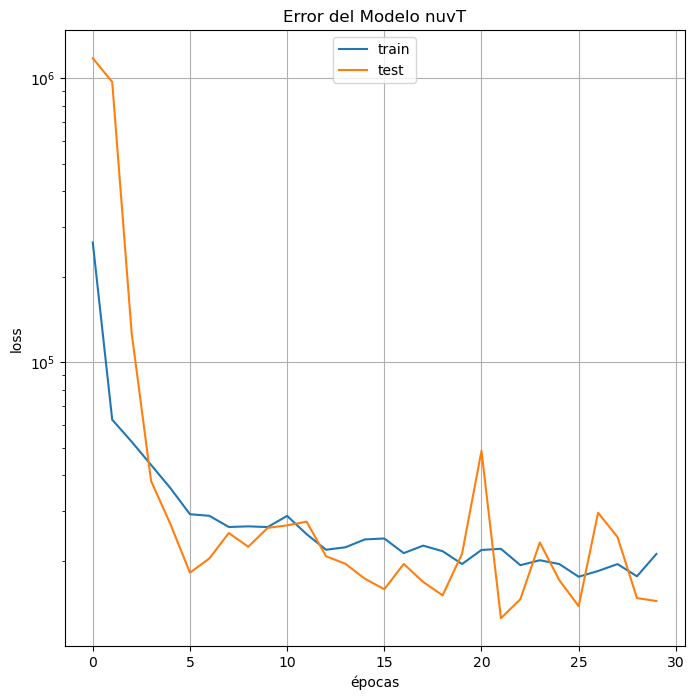

In [9]:
plt.figure(1, figsize=(8,8))
plt.plot(history_t_max.history['mse'])
plt.plot(history_t_max.history['val_mse'])

plt.yscale("log")
plt.title('Error del Modelo nuvT')
plt.ylabel('loss')
plt.xlabel('épocas')
plt.grid()
plt.legend(['train', 'test'], loc='upper center')
plt.show()

Es importante verificar hasta donde sea posible la distribución de errores. En la siguiente gráfica se muestra el pronóstico contra los datos reales.

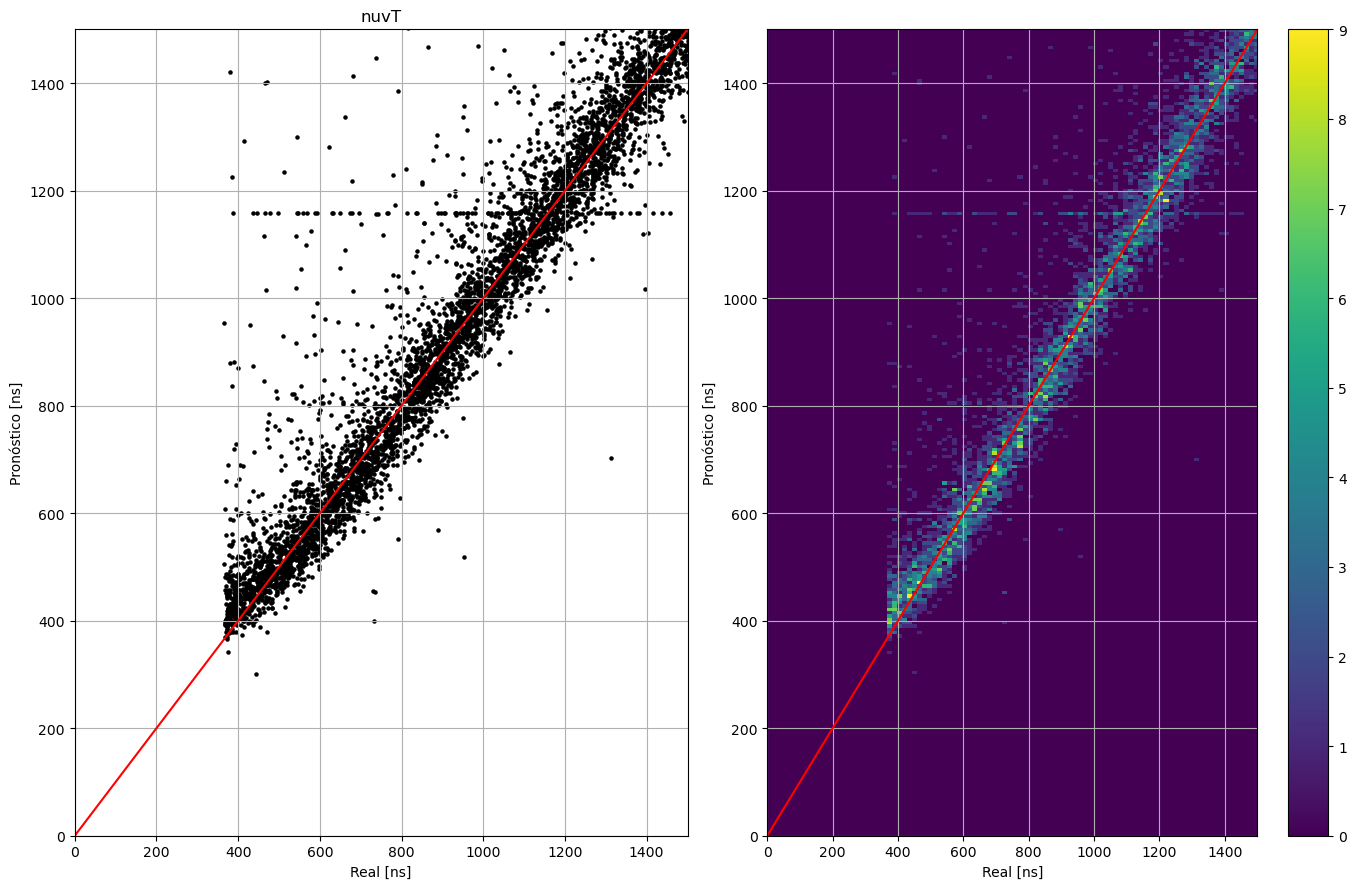

In [15]:
fig, axs = plt.subplots(1,2,figsize=(14,9))

axs[0].scatter(test_nuvT, nuvT_pred_max, color="black",s=5)
axs[0].grid()

axs[0].plot([0,1500],[0,1500],color="r")
axs[0].title.set_text('nuvT')
axs[0].set_xlim([0,1500])
axs[0].set_ylim([0,1500])
axs[0].set_ylabel('Pronóstico [ns]')
axs[0].set_xlabel('Real [ns]')


im1 = axs[1].hist2d(test_nuvT, nuvT_pred_max.flatten(), bins=(100, 300), cmap='viridis',cmax=30)
fig.colorbar(im1[3], ax=axs[1])
axs[1].grid()

axs[1].plot([0,1500],[0,1500],color="r")
axs[1].set_xlim([0,1500])
axs[1].set_ylim([0,1500])
axs[1].set_ylabel('Pronóstico [ns]')
axs[1].set_xlabel('Real [ns]')
axs[1].set_facecolor('#440154')

fig.tight_layout()

# plt.savefig('/tmp/CNNx2+4T+N_Recta_I.png', dpi=300)

Finalmente se realizan ajustes gaussianos al error entre pronóstico y datos reales para comprobar la calidad de los resultados.

------------------
Media nuvT = 5.580523491402194
Sigma nuvT = 52.49821478635204
------------------


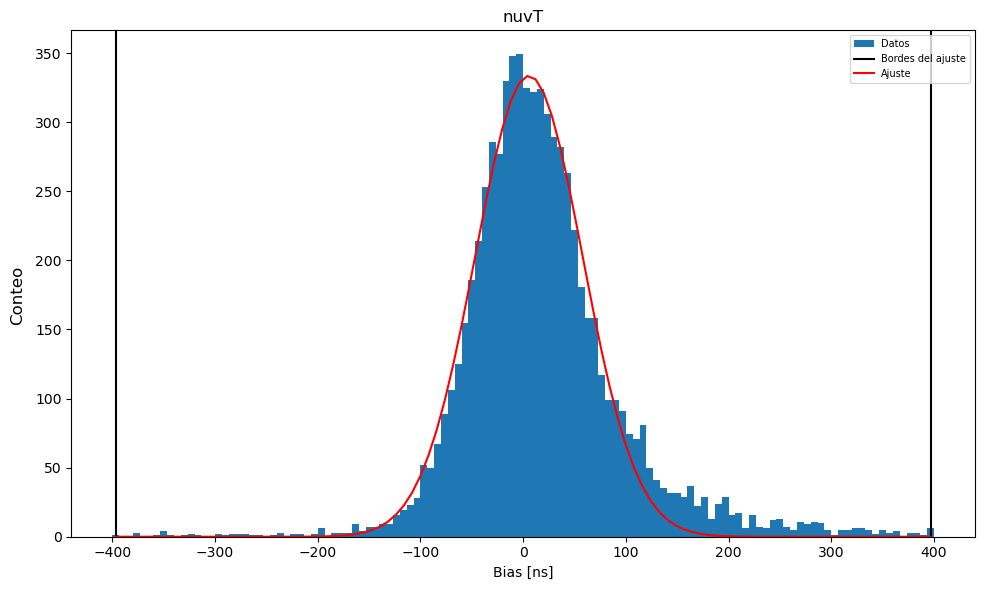

In [16]:
# Ajuste gaussiano de las diferencias entre el pronóstico y el valor real

from scipy.optimize import curve_fit

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Variables de los histogramas
diff_nuvT = nuvT_pred_max.flatten()-test_nuvT

fig, axs = plt.subplots(figsize=(10,6))

# Valores de X
axs.title.set_text('nuvT')
counts_nuvT, bins_nuvT, patches_nuvT = axs.hist(diff_nuvT,120, range=[-400,400], label='Datos')

step_nuvT = (bins_nuvT[1]-bins_nuvT[0])/2
bin_centers_nuvT = bins_nuvT[:-1]+step_nuvT

ini_nuvT = 0
fin_nuvT = 119
axs.axvline(x = bin_centers_nuvT[ini_nuvT], color = 'k', label='Bordes del ajuste')
axs.axvline(x = bin_centers_nuvT[fin_nuvT], color = 'k')

popt_nuvT, pcov_nuvT = curve_fit(func, bin_centers_nuvT[ini_nuvT:fin_nuvT+1], counts_nuvT[ini_nuvT:fin_nuvT+1])


ym_nuvT = func(np.linspace(bin_centers_nuvT[ini_nuvT], bin_centers_nuvT[fin_nuvT],100), popt_nuvT[0], popt_nuvT[1], popt_nuvT[2])
axs.plot(np.linspace(bin_centers_nuvT[ini_nuvT], bin_centers_nuvT[fin_nuvT],100), ym_nuvT, c='r', label='Ajuste')
axs.set_xlabel('Bias [ns]')
axs.legend(prop = { "size": 7 })

fig.supylabel('Conteo')
fig.tight_layout()

# plt.savefig('/tmp/CNNx2+4T+N_Distrib_I.png', dpi=300)

print('------------------')
print('Media nuvT =',popt_nuvT[1])
print('Sigma nuvT =',popt_nuvT[2])
print('------------------')


In [17]:
print('Gauss nuvT')
print(np.std(diff_nuvT))
print(np.mean(diff_nuvT))

Gauss nuvT
115.17707820363492
24.574550175010334


## Relación entre nuvT y ophit_time

In [110]:
hit_t_filtered_new5 = [
    ak.mean(ak.flatten(filtered)) if len(ak.flatten(filtered)) > 0 else 0 
    for array in hit_t_filtered
    for filtered in [array]]

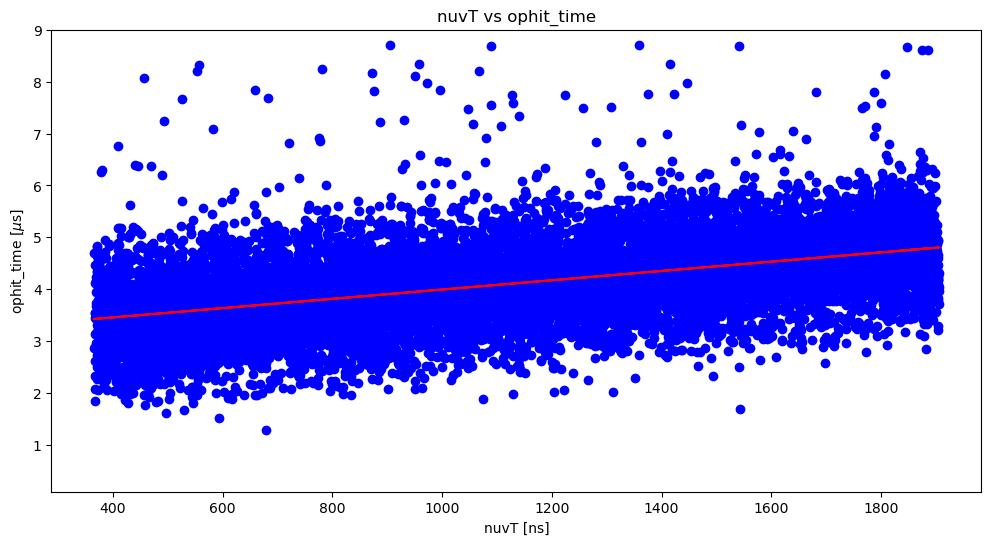

In [109]:
flat_nuvT_np = ak.to_numpy(flat_nuvT)
hit_t_filtered_new3_np = ak.to_numpy(hit_t_filtered_new3)


# Realizar el ajuste lineal
coeffs = np.polyfit(flat_nuvT_np, hit_t_filtered_new3_np, 1)  # Grado 1 para una línea recta
slope, intercept = coeffs

# Crear la línea ajustada
fit_line = slope * flat_nuvT_np + intercept

plt.figure(figsize=(12, 6))
plt.scatter(flat_nuvT_np, hit_t_filtered_new3_np, marker='o', linestyle='-', color='b')
plt.plot(flat_nuvT_np, fit_line, color='r', label=f'Ajuste lineal: y = {slope:.2f}x + {intercept:.2f}')

# Adding labels and title
plt.xlabel('nuvT [ns]')
plt.ylabel(r'ophit_time [$\mu$s]')
plt.title('nuvT vs ophit_time')
plt.ylim(0.1,9)
# Show the plot
plt.show()